In [2]:
# Data Prep
# Install required lib

import os, glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import nrrd

In [3]:
# Load and visualize data
dataInputPath = '/home/tester/kong/volume/'
imagePathInput = os.path.join(dataInputPath, 'image/')
maskPathInput = os.path.join(dataInputPath, 'mask/')

dataOutputPath = '/home/tester/kong/slices/'
imageSliceOutput = os.path.join(dataOutputPath, 'image/')
maskSliceOutput = os.path.join(dataOutputPath, 'mask/')

# STEP 2 - Image normalization, set hounsfield number to min max or P1_image
HOUNSFIELD_MIN = -1000
HOUNSFIELD_MAX = 5000
HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN

# STEP 3 - Slicing in x, y, z directions; only slice in z dir to keep input shape of image slice the same
SLICE_X = False
SLICE_Y = False
SLICE_Z = True

SLICE_DECIMATE_IDENTIFIER = 3

In [4]:
# Load image and see max min Hounsfield units
imgPath = os.path.join(imagePathInput, 'P1_image.nrrd')
readdata, header = nrrd.read(imgPath)
img = readdata
np.min(img), np.max(img), img.shape, type(img)

(-1000.0, 5013.0, (512, 512, 122), numpy.ndarray)

In [5]:
# Load mask and see max min Hounsfield units 
maskPath = os.path.join(maskPathInput, 'P1_mask.nrrd')
readdata, header = nrrd.read(maskPath)
mask = readdata
np.min(mask), np.max(mask), mask.shape, type(mask)

(0.0, 1.0, (512, 512, 122), numpy.ndarray)

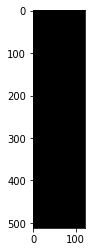

In [6]:
# Show image slice
imgSlice = mask[20,:,:]
plt.imshow(imgSlice, cmap='gray')
plt.show()

In [7]:
# Normalize image
def normalizeImageIntensityRange(img):
    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img - HOUNSFIELD_MIN) / HOUNSFIELD_RANGE

nImg = normalizeImageIntensityRange(img)
np.min(nImg), np.max(nImg), nImg.shape, type(nImg)

(0.0, 1.0, (512, 512, 122), numpy.ndarray)

In [8]:
# Read image or mask volume
def readImageVolume(imgPath, normalize=False):
    img, header = nrrd.read(imgPath)
    if normalize:
        return normalizeImageIntensityRange(img)
    else:
        return img

# image need to normalise
# mask DO NOT need to normalise    
readImageVolume(imgPath, normalize=True)
readImageVolume(maskPath, normalize=False)

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [9]:
# Save volume slice to file
def saveSlice(img, fname, path):
    img = np.uint8(img * 255)
    fout = os.path.join(path, f'{fname}.png')
    cv2.imwrite(fout, img)
    print(f'[+] Slice saved: {fout}', end='\r')
    
saveSlice(nImg[20,:,:], 'test', imageSliceOutput)
saveSlice(mask[20,:,:], 'test', maskSliceOutput)

In [10]:
# Slice image in all directions and save
def sliceAndSaveVolumeImage(vol, fname, path):
    (dimx, dimy, dimz) = vol.shape
    print(dimx, dimy, dimz)
    cnt = 0
    if SLICE_X:
        cnt += dimx
        print('Slicing X: ')
        for i in range(dimx):
            saveSlice(vol[i,:,:], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_x', path)
            
    if SLICE_Y:
        cnt += dimy
        print('Slicing Y: ')
        for i in range(dimy):
            saveSlice(vol[:,i,:], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_y', path)
            
    if SLICE_Z:
        cnt += dimz
        print('Slicing Z: ')
        for i in range(dimz):
            saveSlice(vol[:,:,i], fname+f'-slice{str(i+1).zfill(SLICE_DECIMATE_IDENTIFIER)}_z', path)
    return cnt

In [11]:
# To do alphanumeric sorting (natural sorting) to slice the patients file in proper naming sequence

import re
def sorted_alnum( l ):
    """ Sorts the given iterable in the way that is expected.
 
    Required arguments:
    l -- The iterable to be sorted.
 
    """
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key = alphanum_key)

In [11]:
# Read and process image volumes
for index, filename in enumerate(sorted_alnum(glob.iglob(imagePathInput+'*.nrrd'))):
    img = readImageVolume(filename, True)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 'P'+str(index+1), imageSliceOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

/home/tester/kong/volume/image/P1_image.nrrd (512, 512, 122) 1146 0.0 1.0
512 512 122
Slicing Z: 
[+] Slice saved: /home/tester/kong/slices/image/P1-slice122_z.png
/home/tester/kong/volume/image/P1_image.nrrd, 122 slices created 

/home/tester/kong/volume/image/P2_image.nrrd (512, 512, 98) 1122 0.0 0.6785
512 512 98
Slicing Z: 
[+] Slice saved: /home/tester/kong/slices/image/P2-slice098_z.png
/home/tester/kong/volume/image/P2_image.nrrd, 98 slices created 

/home/tester/kong/volume/image/P3_image.nrrd (512, 512, 138) 1162 0.0 1.0
512 512 138
Slicing Z: 
[+] Slice saved: /home/tester/kong/slices/image/P3-slice138_z.png
/home/tester/kong/volume/image/P3_image.nrrd, 138 slices created 

/home/tester/kong/volume/image/P4_image.nrrd (512, 512, 87) 1111 0.0 1.0
512 512 87
Slicing Z: 
[+] Slice saved: /home/tester/kong/slices/image/P4-slice087_z.png
/home/tester/kong/volume/image/P4_image.nrrd, 87 slices created 

/home/tester/kong/volume/image/P5_image.nrrd (512, 512, 95) 1119 0.0 0.6785
512

In [13]:
# Read and process image mask volumes
for index, filename in enumerate(sorted_alnum(glob.iglob(maskPathInput+'*.nrrd'))):
    img = readImageVolume(filename, False)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 'P'+str(index+1), maskSliceOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

/home/tester/kong/volume/mask/P1_mask.nrrd (512, 512, 122) 1146 0.0 1.0
512 512 122
Slicing Z: 
[+] Slice saved: /home/tester/kong/slices/mask/P1-slice122_z.png
/home/tester/kong/volume/mask/P1_mask.nrrd, 122 slices created 

/home/tester/kong/volume/mask/P2_mask.nrrd (512, 512, 98) 1122 0.0 1.0
512 512 98
Slicing Z: 
[+] Slice saved: /home/tester/kong/slices/mask/P2-slice098_z.png
/home/tester/kong/volume/mask/P2_mask.nrrd, 98 slices created 

/home/tester/kong/volume/mask/P3_mask.nrrd (512, 512, 138) 1162 0.0 1.0
512 512 138
Slicing Z: 
[+] Slice saved: /home/tester/kong/slices/mask/P3-slice138_z.png
/home/tester/kong/volume/mask/P3_mask.nrrd, 138 slices created 

/home/tester/kong/volume/mask/P4_mask.nrrd (512, 512, 87) 1111 0.0 1.0
512 512 87
Slicing Z: 
[+] Slice saved: /home/tester/kong/slices/mask/P4-slice087_z.png
/home/tester/kong/volume/mask/P4_mask.nrrd, 87 slices created 

/home/tester/kong/volume/mask/P5_mask.nrrd (512, 512, 95) 1119 0.0 1.0
512 512 95
Slicing Z: 
[+] Slic